# Word2vec + K-means

First, we need to create word vectors. For simplicity, we will use a pretrained Word2Vec model
with Ukrainian words-vectors, each of which has a dimension of 300.

This sample of word vectors was created on the basis of neews feed. We chose the lematized version of this model because we already have our sample, which we processed in the previous part, which would fit perfectly here.

The model can be found on [this website](https://lang.org.ua/uk/models/).

In [5]:
import numpy as np
import pandas as pd
import pickle
import gensim, logging
import gensim.models.keyedvectors as word2vec
import matplotlib.pyplot as plt

%matplotlib inline

Also let's write a style for alignment in the middle of all graphs, images, etc:

# Data

In [7]:
# Importing prepared dataset
import pickle
input = open('my_corpus.pql', 'rb')
obj = pickle.load(input)
input.close()

corpus = obj['corpus']
words_list = obj['words_list']
all_words = obj['all_words']
print(corpus[1])

народитися дивитися категорія народитися грехема макферсон англійський співак джулія дрейфус американський актриса майя чибурданідзе грузинський шахістка уейн грецкий канадський хокеїст лютий геннадій куцак заслужений лютий вінс нейл американський співак лютий енді тейлор англійський музикант лютий коротаєв андрій віталійович історик філософ соціолог орієнталіст лютий джон американський музикант олена олексіївна яковлев російський кіноактриса лотар маттеус німецький футболіст олександр цекати співак василь радянський футболіст едді мерфі актор олександр заваров футболіст травень джей астон співак травень джордж клуня американський актор травень кемпбелл музикант травень денніс родмен американський баскетболіст травень англійський кіноактор травень томпсон актриса майкл фокс актор джордж англійський співак елісон співачка наталія марія петрівна фарина співачка сопрано педагог заслужений артистка


In [8]:
print("Number of documents:", len(corpus), len(words_list))

Number of documents: 4626 4626


# W2V

Now we will load our word2vec model. 

This may take some time, as the model contains 174 311  words, so we will get a 174 311 x 300 embedding matrix that contains all the values of the word vectors.

In [9]:
model = word2vec.KeyedVectors.load_word2vec_format('ubercorpus.lowercased.lemmatized.word2vec.300d.txt', binary=False)

Now let's get a list of all the words from our dictionary:

In [10]:
words = list(model.key_to_index)

In [11]:
def txt_embed(words, corpus):
    x_sent_embed = []
    count_words, count_non_words = 0, 0  
    
    # recover the embedding of each sentence with the average of the vector that composes it
    # sent - sentence
    for sent in corpus:
        # average embedding of all words in a sentence
        sent_embed = []
        for word in sent:
            try:
                # if word is present in the dictionary - add its vector representation
                count_words += 1
                sent_embed.append(model[word])
            except KeyError:
                # if word is not in the dictionary - add a zero vector
                count_non_words += 1
                sent_embed.append([0] * 300)
        
        # add a sentence vector to the list
        x_sent_embed.append(np.mean(sent_embed, axis=0).tolist())
                    
    print(count_non_words, "out of", count_words, "words were not found in the vocabulary.")
    
    return x_sent_embed

In [12]:
x = txt_embed(words, words_list)

92296 out of 740740 words were not found in the vocabulary.


In [13]:
embed = []
for i,v in enumerate(x): 
    if np.any(np.isnan(v)) != True:
        embed.append(np.array(v))
    else:
        embed.append(np.array([0] * 300))
        print(i)
em = np.vstack(embed).astype('float16')

# K-means

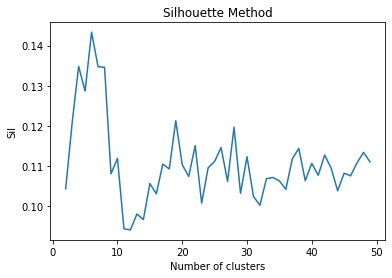

2:0.10437977280794648
3:0.12077331168429267
4:0.1348431773877156
5:0.12870353807087972
6:0.1433389906220242
7:0.13476782789071942
8:0.13460308472311647
9:0.10811021425185358
10:0.11195096599324754
11:0.09441368387246812
12:0.09414176897381556
13:0.09808956811932534
14:0.0967299642407016
15:0.10567864636411596
16:0.10314737660280945
17:0.11052596755572583
18:0.109313243413382
19:0.12132382811901046
20:0.11037811173123324
21:0.10744807780786086
22:0.11513097994014165
23:0.10082298111425056
24:0.10960498498270202
25:0.11117736545711801
26:0.11464193014787626
27:0.10623111327124783
28:0.11969438674327677
29:0.1032690641253545
30:0.11237001026698058
31:0.10248264480310575
32:0.10027677978752352
33:0.10687719349927445
34:0.1071861079388446
35:0.10633865678757902
36:0.10424310112434683
37:0.11183872204575819
38:0.11442218814839414
39:0.10636760211074278
40:0.11070767220768085
41:0.10774978867500162
42:0.11276326025821419
43:0.1094641713243344
44:0.1038922532851574
45:0.10825301480624423
46:0.

In [14]:
# Silhouette method to find the optimal number of clusters
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil = []

for k in range(2, 50):
  kmeans = KMeans(n_clusters = k).fit(em)  
  preds = kmeans.fit_predict(em)
  sil.append(silhouette_score(em, preds, metric = 'euclidean'))


plt.plot(range(2, 50), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sil')
plt.show()

for i in range(len(sil)):
 print(str(i+2) +":"+ str(sil[i]))

In [31]:
# Number of Clusters
k = 8

In [32]:
# K-means clustering
from sklearn.cluster import KMeans

km = KMeans(n_clusters = k)
%time km.fit(em)

Wall time: 3.46 s


KMeans()

## Clusters descriptions

In [33]:
def descriptions(name, labels):
    posts = { 'corpus': corpus, 'cluster': labels }
    posts = pd.DataFrame(posts)
    words_from_clusters = posts.groupby(['cluster'])['corpus'].apply(lambda x: "%s" % ' '.join(x))
    
    names = []
    for cluster in words_from_clusters:
            words_freq = FreqDist(cluster.split(' '))
            names.append(words_freq.most_common(1)[0][0])
            print('Cluster: ', cluster.title)
            print('Most popular words: ', words_freq.most_common(10))
            print('Total number of unique words: ', len(words_freq))
            print('\n')
            
    # Clusters cores
    cores = pd.DataFrame({'names':names})
    cores['shares'] = (posts.groupby(['cluster']).count()/len(labels)*100).round(2)
    print(cores)

In [34]:
from nltk import FreqDist
descriptions('kmw2v', km.labels_.tolist())
clusters = pd.DataFrame(km.labels_.tolist())
clusters.columns = ['kmw2v']

Cluster:  <built-in method title of str object at 0x0000020D406CD060>
Most popular words:  [('мова', 1971), ('найкращий', 1144), ('премія', 972), ('фільм', 898), ('режисер', 445), ('виставка', 409), ('приз', 371), ('фортепіано', 354), ('народний', 332), ('чоловічий', 329)]
Total number of unique words:  14455


Cluster:  <built-in method title of str object at 0x0000020D40F3D040>
Most popular words:  [('неуточнений', 1072), ('родовище', 433), ('новоутворення', 407), ('засіб', 384), ('населення', 344), ('порушення', 337), ('злоякісний', 316), ('ураження', 301), ('виключаючи', 301), ('система', 288)]
Total number of unique words:  18939


Cluster:  <built-in method title of str object at 0x0000020D4041B010>
Most popular words:  [('категорія', 3484), ('риби', 548), ('футболіст', 515), ('футбольний', 283), ('гравець', 278), ('легіонер', 259), ('кубок', 196), ('ссавець', 159), ('розіграш', 154), ('олімпійський', 146)]
Total number of unique words:  1541


Cluster:  <built-in method title of

## W2V AgglomerativeClustering

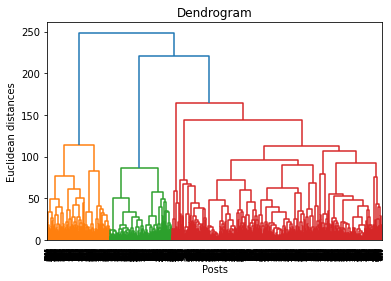

In [35]:
# Using the dendrogram to find the optimal number of clusters
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(em, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Posts')
plt.ylabel('Euclidean distances')
plt.show()

In [36]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward').fit_predict(em)

In [37]:
descriptions('agw2v', hc)
clusters['agw2v'] = hc

Cluster:  <built-in method title of str object at 0x0000020D49D17040>
Most popular words:  [('фільм', 1197), ('найкращий', 1172), ('премія', 1122), ('орден', 740), ('режисер', 657), ('великий', 595), ('святий', 593), ('іван', 563), ('місце', 552), ('джон', 549)]
Total number of unique words:  53470


Cluster:  <built-in method title of str object at 0x0000020D4A0E3040>
Most popular words:  [('неуточнений', 1057), ('родовище', 435), ('засіб', 398), ('система', 398), ('новоутворення', 389), ('порушення', 323), ('злоякісний', 304), ('ураження', 300), ('класифікований', 286), ('виключаючи', 266)]
Total number of unique words:  11254


Cluster:  <built-in method title of str object at 0x0000020D4A21E040>
Most popular words:  [('файл', 1064), ('лівий', 700), ('право', 678), ('місце', 645), ('полк', 547), ('дивізія', 528), ('притока', 412), ('закінчити', 408), ('річка', 367), ('піхотний', 348)]
Total number of unique words:  43112


Cluster:  <built-in method title of str object at 0x0000020D

## MeanShift

In [69]:
from sklearn.cluster import MeanShift
mshift = MeanShift(bandwidth=11).fit(em)

In [70]:
descriptions('msw2v', mshift.labels_)
clusters['msw2v'] = mshift.labels_

Cluster:  <built-in method title of str object at 0x0000020D4FDB0040>
Most popular words:  [('категорія', 3649), ('олександр', 2572), ('мова', 2367), ('іван', 2361), ('володимир', 2157), ('микола', 2097), ('іванович', 1685), ('наука', 1652), ('вулиця', 1644), ('файл', 1615)]
Total number of unique words:  120436


Cluster:  <built-in method title of str object at 0x0000020D06DA9050>
Most popular words:  [('місце', 579), ('закінчити', 382), ('дивізіон', 127), ('група', 105), ('клас', 82), ('16px', 31), ('гран', 23), ('категорія', 19), ('містер', 17), ('олімпія', 17)]
Total number of unique words:  48


Cluster:  <built-in method title of str object at 0x0000020D4CEC2AF0>
Most popular words:  [('населення', 338), ('санта', 20), ('бальєс', 16), ('перепис', 11), ('врахувати', 10), ('тисяча', 10), ('житель', 10), ('сант', 8), ('марія', 8), ('срср', 7)]
Total number of unique words:  220


Cluster:  <built-in method title of str object at 0x0000020D3E5A0290>
Most popular words:  [('світовий'

## HDBSCAN

In [67]:
import hdbscan
hdb = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=8)
hdb.fit(em)

HDBSCAN(min_cluster_size=8, min_samples=8)

In [ ]:
descriptions('hdbw2v', hdb.labels_)
clusters['hdbw2v'] = hdb.labels_

## UMAP

In [43]:
#!pip install umap-learn

In [95]:
import umap
mapper = umap.UMAP(n_neighbors=10, min_dist=0.15, n_components=2, metric='cosine').fit(em)

In [45]:
#!pip install datashader
#!pip install bokeh 
#!pip install holoviews 
#!pip install scikit-image
#!pip install colorcet

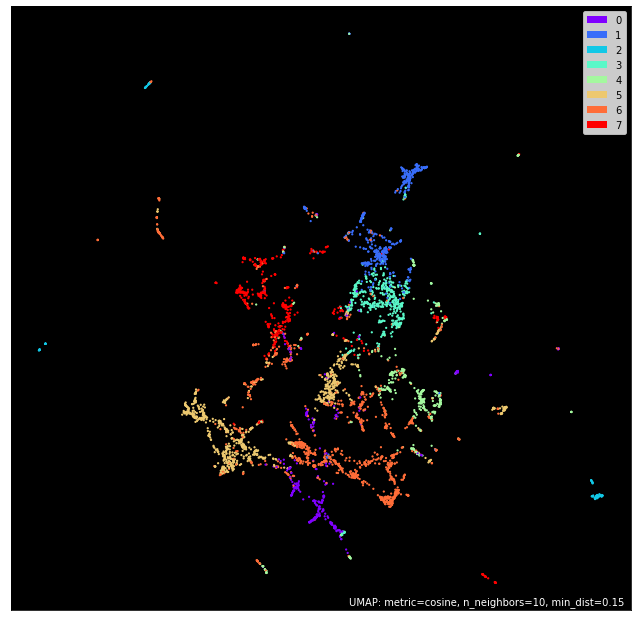

In [96]:
import umap.plot
umap.plot.points(mapper, labels=np.array(clusters.kmw2v), theme='fire')
umap.plot.plt.show()

## UMAP+DBSCAN

In [115]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.15, n_components=2, metric='cosine', n_epochs=50)
X_umap = reducer.fit_transform(em)
umap_cl = hdbscan.HDBSCAN(min_cluster_size=75, min_samples=55).fit(X_umap)

In [116]:
descriptions('umapw2v', umap_cl.labels_)
clusters['umapw2v'] = umap_cl.labels_

Cluster:  <built-in method title of str object at 0x0000020D231C0040>
Most popular words:  [('категорія', 3594), ('мова', 2173), ('вулиця', 1494), ('найкращий', 1181), ('місце', 1153), ('сільський', 1118), ('премія', 1013), ('герб', 891), ('наука', 876), ('право', 835)]
Total number of unique words:  64998


Cluster:  <built-in method title of str object at 0x0000020D41E7B210>
Most popular words:  [('полк', 652), ('дивізія', 574), ('піхотний', 380), ('командир', 370), ('гвардійський', 281), ('дніпропетровськ', 279), ('харківський', 274), ('артилерійський', 270), ('окремий', 244), ('андріївка', 216)]
Total number of unique words:  14435


Cluster:  <built-in method title of str object at 0x0000020D41CCFAF0>
Most popular words:  [('неуточнений', 1026), ('новоутворення', 407), ('злоякісний', 317), ('порушення', 312), ('ураження', 299), ('класифікований', 289), ('виключаючи', 280), ('уточнений', 242), ('орган', 204), ('ускладнення', 175)]
Total number of unique words:  5623


Cluster:  <bu

In [ ]:
def plot_2d(X, label_list_cluster):
    plt.figure(figsize=(7, 7))
    plt.subplots_adjust(bottom=0.1)
    c = label_list_cluster
    plt.scatter(X[:, 0], X[:, 1], c=c, cmap='rainbow', label='True Position')
    plt.show()

In [ ]:
plot_2d(X_umap,umap_cl.labels_)

# Matching

In [117]:
# Importing prepared dataset
input = open('tfidf-clusters.pql', 'rb')
obj = pickle.load(input)
input.close()
tfidf = obj['clusters']

In [118]:
df = tfidf.merge(clusters, left_index=True, right_index=True)

In [119]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import v_measure_score

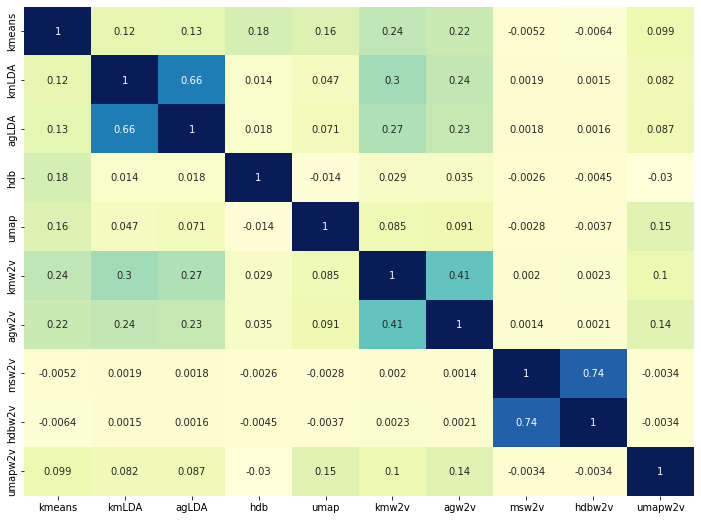

In [120]:
# Adjusted randscore
rand = []
for column1 in df.columns:
    ra = []
    for column2 in df.columns:
        r = adjusted_rand_score(df[column1],df[column2])
        ra.append(r)
    rand.append(np.array(ra))    
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(pd.DataFrame(np.array(rand), index = df.columns, columns = df.columns), annot=True, cmap="YlGnBu",  cbar=False)
plt.show()

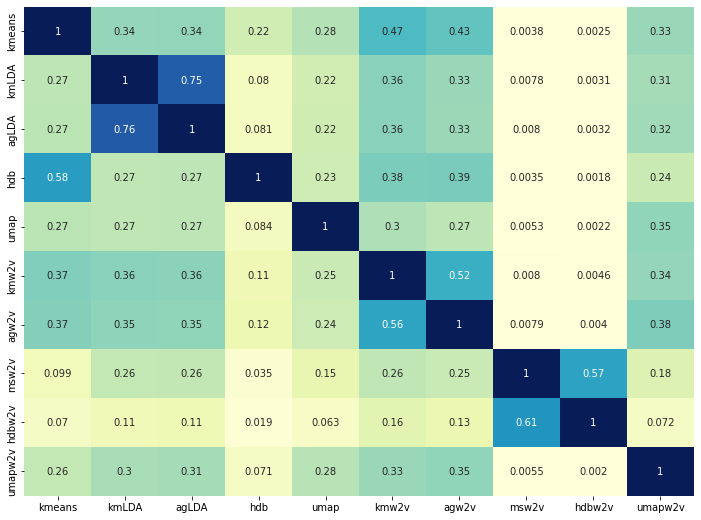

In [121]:
# Homogeneity Score
rand = []
for column1 in df.columns:
    ra = []
    for column2 in df.columns:
        r = homogeneity_score(df[column1],df[column2])
        ra.append(r)
    rand.append(np.array(ra))    
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(pd.DataFrame(np.array(rand), index = df.columns, columns = df.columns), annot=True, cmap="YlGnBu",  cbar=False)
plt.show()

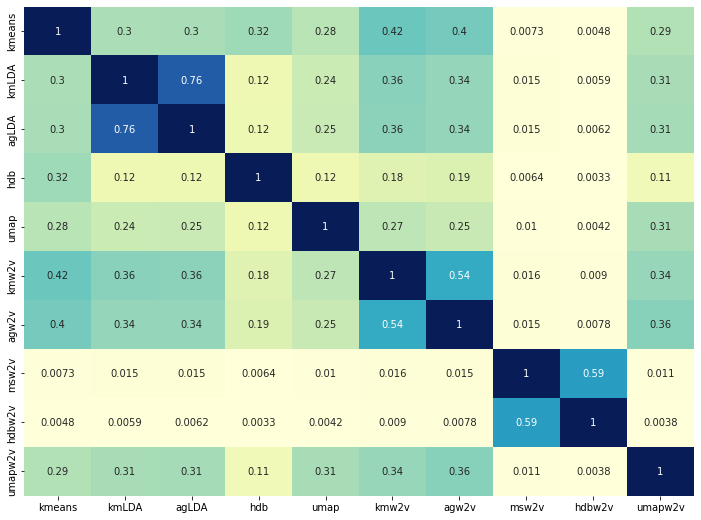

In [122]:
# V-measure Score
rand = []
for column1 in df.columns:
    ra = []
    for column2 in df.columns:
        r = v_measure_score(df[column1],df[column2])
        ra.append(r)
    rand.append(np.array(ra))    
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(pd.DataFrame(np.array(rand), index = df.columns, columns = df.columns), annot=True, cmap="YlGnBu",  cbar=False)
plt.show()